In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Enable quiet mode to hide verbose output
!pip install -q nilearn

# Ensure a stable PyTorch version
!pip install -q torch==2.5.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install compatible PyG wheels for torch 2.5.1 + cu121
!pip install -q torch-geometric==2.6.1

# Check installations
import torch, nilearn
import torch_geometric
print("Torch:", torch.__version__)
print("Nilearn:", nilearn.__version__)
print("PyG:", torch_geometric.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 130.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [53]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from nilearn.plotting import plot_connectome, plot_matrix, show
from sklearn.decomposition import PCA

In [4]:
corr_dir = '/content/drive/Shareddrives/291A_Brain_Connectomes/FullCorrelationSubjects'

subject_ids = [
  os.path.splitext(f)[0]
  for f in os.listdir(corr_dir)
  if f.endswith(".csv")
]

phen_df = pd.read_csv('/content/drive/Shareddrives/291A_Brain_Connectomes/AABC_Release1_Non-imaging_Data-XL.csv', usecols=[0, 7, 381, 475, 2343], header=1) # 0 - subject_id, 7 - age, 381 - moca_sum, 476 - ravlt_learning_score
phen_df.head()

id_event age_open  moca_sum  ravlt_learning_score  psqi_global
0  HCA6000030_V1       86      22.0                   1.0          5.0
1  HCA6002236_V1       46      25.0                   7.0          6.0
2  HCA6002236_F1       47       NaN                   NaN          NaN
3  HCA6002236_V2       48      27.0                   9.0          2.0
4  HCA6002236_F2       49       NaN                   NaN          NaN

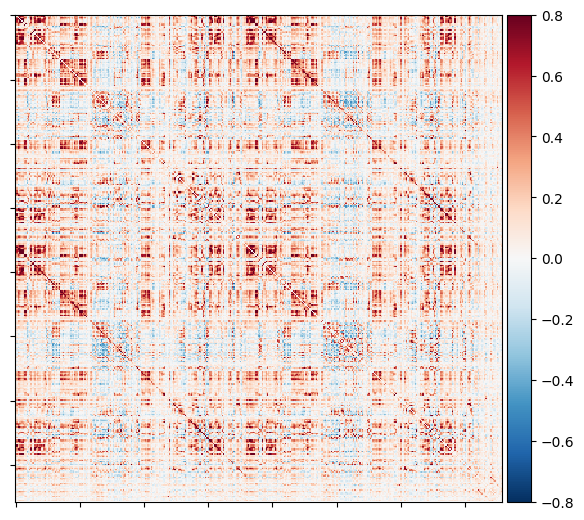

In [5]:
test_subject = subject_ids[0]
fullcorr = pd.read_csv(os.path.join(corr_dir, f"{test_subject}.csv"))
fullcorr = np.array(fullcorr.drop(fullcorr.columns[0], axis=1).select_dtypes(include="number"))
plot_matrix(fullcorr, vmin=-0.8, vmax=0.8)
show()

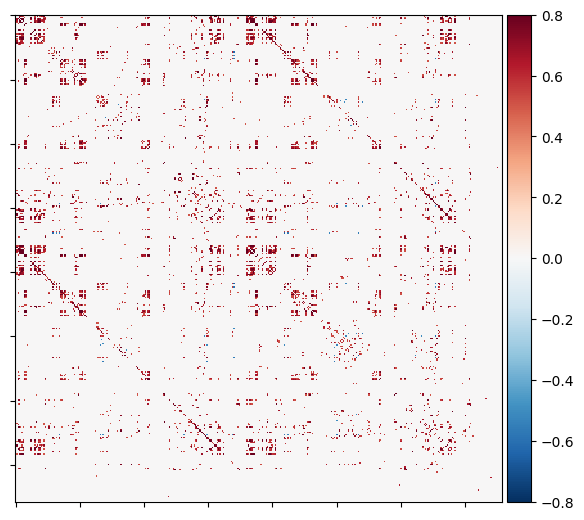

In [6]:
plot_matrix(np.where((np.abs(fullcorr) < 0.5), 0, fullcorr), vmin=-0.8, vmax=0.8)
show()

In [7]:
def pack_upper_triangular(mat, N=379):
  triu_idx = torch.triu_indices(N, N, offset=1)
  return mat[triu_idx[0], triu_idx[1]]

In [8]:
phen = phen_df.set_index('id_event')

dataset = []

for si in subject_ids:
  row_vals = phen.loc[si]
  if row_vals.notna().all():
    filename = f"{si}.csv"
    A = pd.read_csv(os.path.join(corr_dir, filename))
    A_t = torch.from_numpy(np.array(A.drop(A.columns[0], axis=1).select_dtypes(include="number")))
    age=torch.tensor(int(row_vals['age_open'].split()[0]))
    moca=torch.tensor(row_vals['moca_sum'])
    ravlt=torch.tensor(row_vals['ravlt_learning_score'])
    psqi=torch.tensor(row_vals['psqi_global'])

    data = [A_t, age, moca, ravlt, psqi]
    dataset.append(data)

print(len(dataset))

2138


In [31]:
class ConnectomeVAE(nn.Module):
  def __init__(self, N, latent_dim):
    super(ConnectomeVAE, self).__init__()
    self.input_dim = N*(N-1) // 2
    self.output_dim = self.input_dim

    # Encoder
    self.en = nn.Sequential(
        nn.Linear(self.input_dim, 256),
        nn.GELU()
    )
    self.fc_mu = nn.Linear(256, latent_dim)
    self.fc_logvar = nn.Linear(256, latent_dim)

    # Decoder
    self.dec = nn.Sequential(
        nn.Linear(latent_dim, 256),
        nn.GELU(),
        nn.Linear(256, self.output_dim)
    )

  def encode(self, x):
    h = self.en(x)
    return self.fc_mu(h), self.fc_logvar(h)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def decode(self, z):
    return self.dec(z)

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar, kl_weight=1):
  # MSE = F.mse_loss(recon_x, x, reduction='mean')
  FRO = F.torch.norm(recon_x - x, p='fro')
  # KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  KL = -0.5 * torch.mean(torch.sum(
    1 + logvar - mu.pow(2) - logvar.exp(),
    dim=1
  ))
  return FRO + kl_weight*KL, FRO, KL

def train_vae(model, dataloader, optimizer, num_epochs=15, device='cpu'):
  model.to(device)
  for epoch in range(1,num_epochs+1):
    model.train()
    total_loss = 0
    total_mse = 0
    total_kl = 0
    for batch in dataloader:
      batch_data = batch.to(device).float()
      optimizer.zero_grad()
      reconstructed_data, mu, log_var = model(batch_data)
      # kl_weight = min(1.0, epoch / 20)
      loss, mse, kl = loss_function(reconstructed_data, batch_data, mu, log_var)
      total_loss += loss.item()
      total_mse += mse.item()
      total_kl += kl.item()
      loss.backward()
      optimizer.step()
      torch.cuda.empty_cache()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}, Recon Loss:{(total_mse/len(dataloader)):.4f}, KL Loss:{(total_kl/len(dataloader)):.4f}")

  return model

In [28]:
vae_in = []
for data in dataset:
  vae_in.append(pack_upper_triangular(data[0]))

dataloader = DataLoader(vae_in, batch_size=16, shuffle=True)
latent_dim = 8
vae = ConnectomeVAE(N=379, latent_dim=latent_dim)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_vae = train_vae(vae, dataloader, optimizer, num_epochs=30, device=device)

Epoch [1/30], Loss: 163.9179, Recon Loss:159.9133, KL Loss:20.0230
Epoch [2/30], Loss: 120.5553, Recon Loss:117.5060, KL Loss:15.2462
Epoch [3/30], Loss: 111.6099, Recon Loss:108.7958, KL Loss:14.0705
Epoch [4/30], Loss: 108.7949, Recon Loss:105.9530, KL Loss:14.2098
Epoch [5/30], Loss: 107.4450, Recon Loss:104.5695, KL Loss:14.3774
Epoch [6/30], Loss: 106.4141, Recon Loss:103.5614, KL Loss:14.2636
Epoch [7/30], Loss: 105.2429, Recon Loss:102.4006, KL Loss:14.2113
Epoch [8/30], Loss: 104.8210, Recon Loss:101.9749, KL Loss:14.2305
Epoch [9/30], Loss: 104.2067, Recon Loss:101.3288, KL Loss:14.3896
Epoch [10/30], Loss: 103.9687, Recon Loss:101.1107, KL Loss:14.2901
Epoch [11/30], Loss: 103.7977, Recon Loss:100.9161, KL Loss:14.4082
Epoch [12/30], Loss: 103.5270, Recon Loss:100.6754, KL Loss:14.2585
Epoch [13/30], Loss: 103.7389, Recon Loss:100.8376, KL Loss:14.5065
Epoch [14/30], Loss: 103.4822, Recon Loss:100.6110, KL Loss:14.3561
Epoch [15/30], Loss: 103.2724, Recon Loss:100.3962, KL Lo

In [25]:
x = torch.tensor(np.array(vae_in), dtype=torch.float32)
print(x.mean().item(), x.std().item())

0.04736294224858284 0.17702876031398773


In [29]:
with torch.no_grad():
    out1 = trained_vae(vae_in[0].unsqueeze(0).float().to(device))[0]
    out2 = trained_vae(vae_in[1].unsqueeze(0).float().to(device))[0]
    diff = torch.mean(torch.abs(out1 - out2))
    print(diff.item())

0.0727085992693901


In [ ]:
# capturing ~40% of inter-subject variance (0.073/0.177)

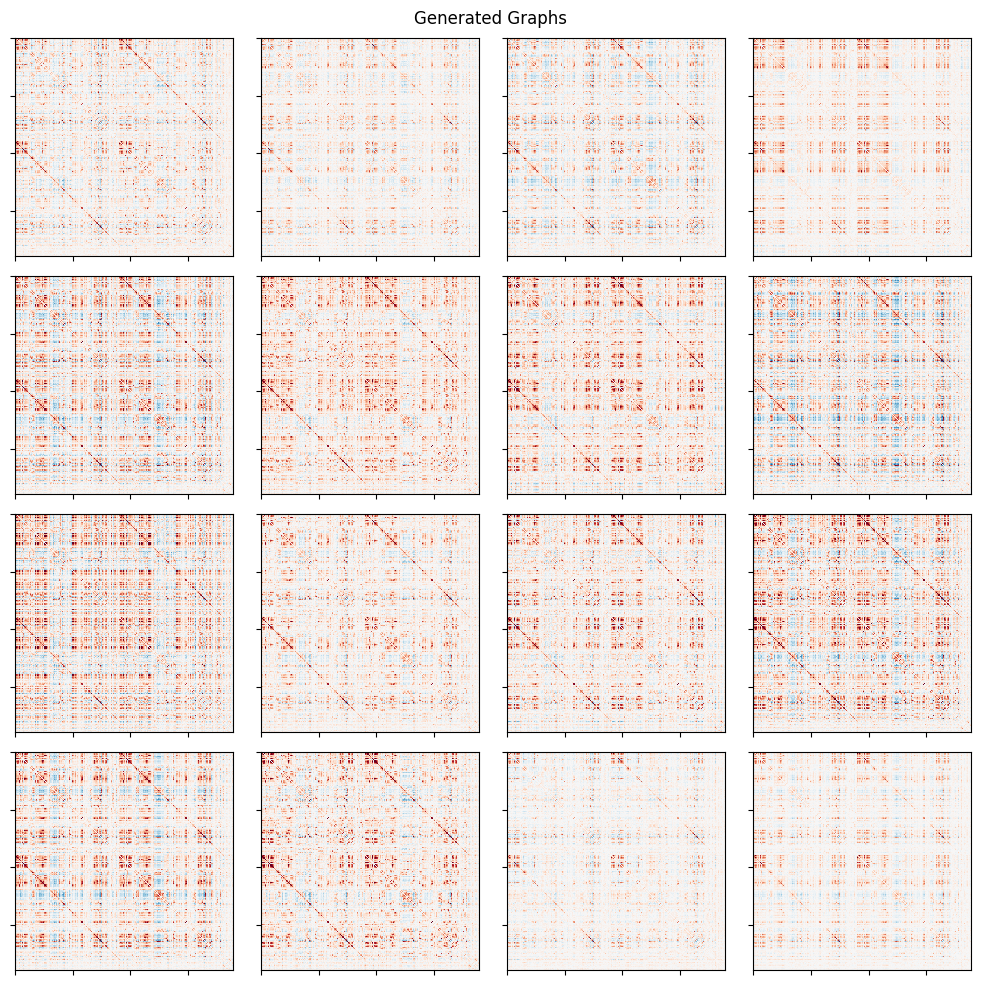

In [39]:
N=379
def sample_latent(latent_dim):
  return torch.randn(1, latent_dim)

def generate_adjacency_matrix(model, latent_dim, device='cpu'):
  model.eval()
  z = sample_latent(latent_dim).to(device)
  with torch.no_grad():
    reconstructed_values = model.decode(z).squeeze(0)

  upper_triangular_size = int((N * (N - 1)) / 2)
  reconstructed_matrix = torch.zeros(N, N, device=device)

  upper_triangular_indices = torch.triu_indices(N, N, offset=1)
  reconstructed_matrix[upper_triangular_indices[0], upper_triangular_indices[1]] = reconstructed_values
  reconstructed_matrix[upper_triangular_indices[1], upper_triangular_indices[0]] = reconstructed_values

  return reconstructed_matrix.cpu().numpy()

def generate_multiple_graphs(model, num_graphs, latent_dim, device='cpu'):
  generated_graphs = []
  for _ in range(num_graphs):
      adj_matrix = generate_adjacency_matrix(model, latent_dim, device)
      generated_graphs.append(adj_matrix)
  return generated_graphs

def plot_multiple_graphs(graphs):
  for i, adj_matrix in enumerate(graphs):
    plot_matrix(adj_matrix, vmin=-0.8, vmax=0.8, title=f"Graph {i + 1}")
    plt.show()

n_rows = 4
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.flatten()

graphs = generate_multiple_graphs(trained_vae, n_rows*n_cols, latent_dim, device=device)

for i in range(n_rows*n_cols):
  ax = axes[i]
  plot_matrix(graphs[i], colorbar=False, vmin=-0.8, vmax=0.8, axes=ax)

plt.suptitle("Generated Graphs")
plt.tight_layout()
plt.show()

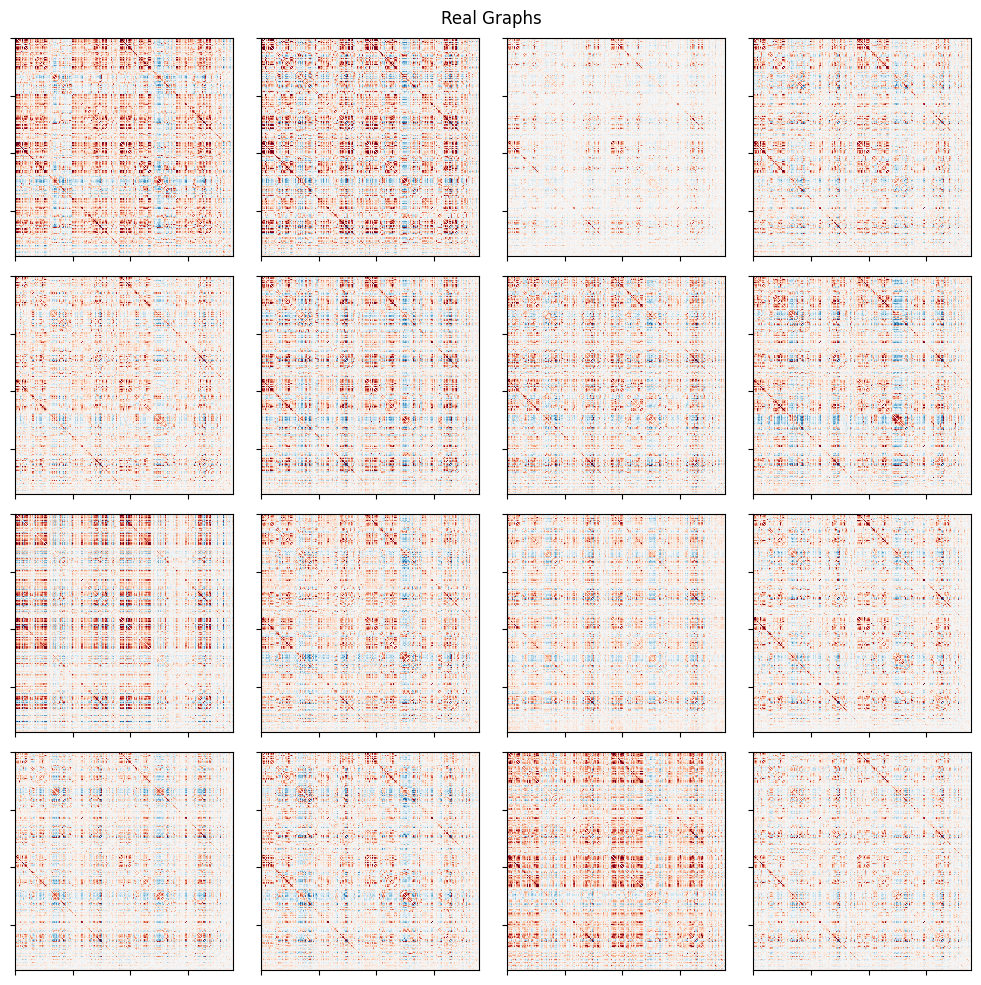

In [68]:
files = os.listdir(corr_dir)
random_subjects = np.random.choice(files, n_rows*n_cols, replace=False)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.flatten()
for i in range(n_rows*n_cols):
  ax = axes[i]
  subject = pd.read_csv(os.path.join(corr_dir, random_subjects[i]))
  subject_mat =  np.array(subject.drop(subject.columns[0], axis=1).select_dtypes(include="number"))
  plot_matrix(subject_mat, colorbar=False, vmin=-0.8, vmax=0.8, axes=ax)
plt.suptitle("Real Graphs")
plt.tight_layout()
plt.show()

In [50]:
def pack_upper_triangular_batch(batch, N=379):
  triu_idx = torch.triu_indices(N, N, offset=1)
  return batch[:, triu_idx[0], triu_idx[1]]

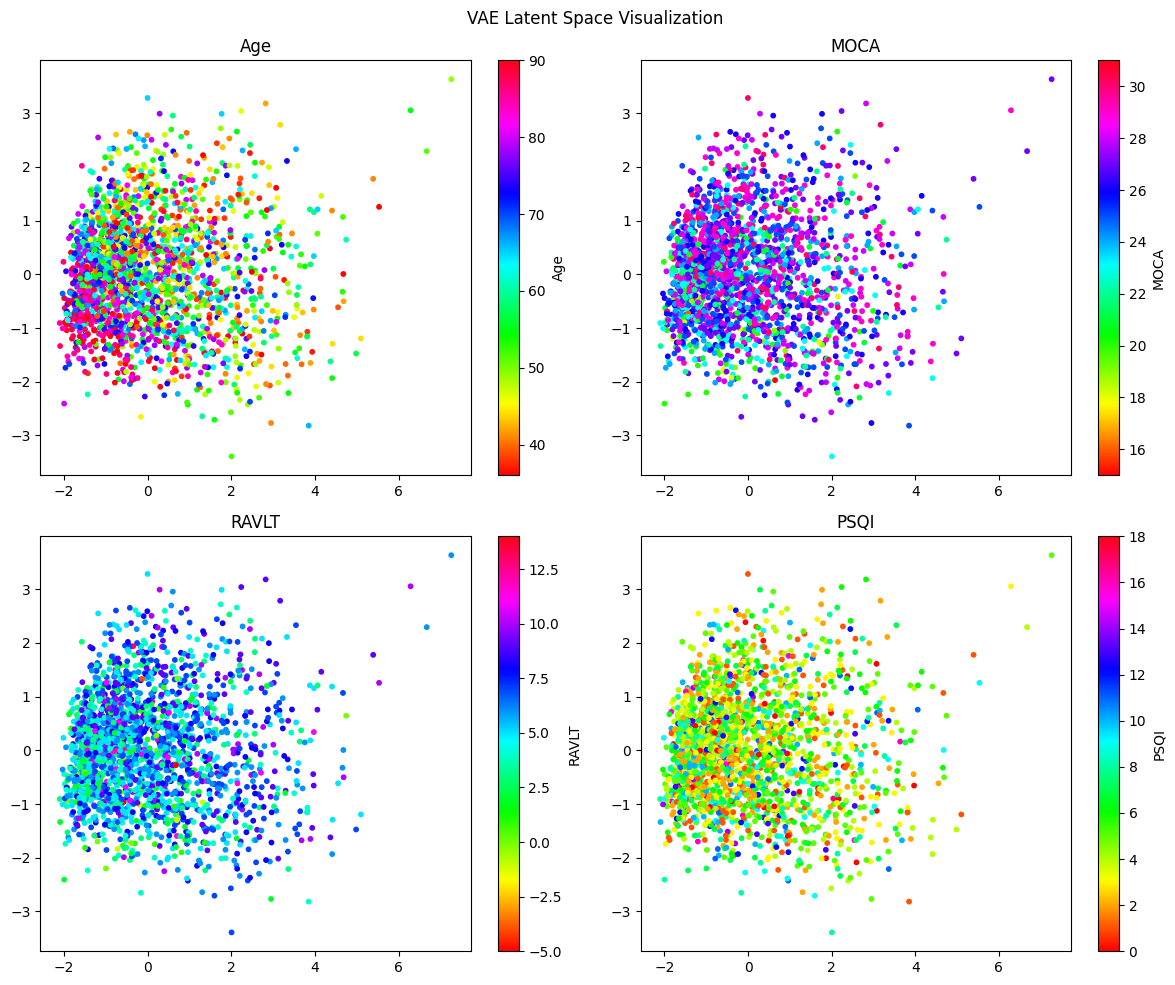

In [66]:
trained_vae.eval()
all_mu = []
all_age = []
all_moca = []
all_ravlt = []
all_psqi = []

eval_loader = DataLoader(dataset, batch_size=16, shuffle=False)

with torch.no_grad():
  for batch in eval_loader:
    batch_upper = pack_upper_triangular_batch(batch[0].to(device).float(), N=379)
    mu, _ = trained_vae.encode(batch_upper)
    all_mu.append(mu.cpu())
    labels_age = batch[1]
    labels_moca = batch[2]
    labels_ravlt = batch[3]
    labels_psqi = batch[4]

    all_age.append(labels_age)
    all_moca.append(labels_moca)
    all_ravlt.append(labels_ravlt)
    all_psqi.append(labels_psqi)

latent = torch.cat(all_mu, dim=0)
latent_2d = PCA(n_components=2).fit_transform(latent.numpy())

n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
all_labels = [torch.cat(all_age),
              torch.cat(all_moca),
              torch.cat(all_ravlt),
              torch.cat(all_psqi)]
titles = ["Age", "MOCA", "RAVLT", "PSQI"]
axes = axes.flatten()

for i in range(n_rows*n_cols):
  ax = axes[i]
  sc = ax.scatter(latent_2d[:,0], latent_2d[:,1], c=all_labels[i], cmap='hsv', s=10)
  cbar = fig.colorbar(sc, ax=ax)
  cbar.set_label(titles[i])
  ax.set_title(titles[i])

plt.suptitle("VAE Latent Space Visualization")
plt.tight_layout()
plt.show()